<span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">⚡ Electricity Production Forecasting ⚡</span>

1. [Libraries and Utilities](#1)
2. [Loading Data](#2)
3. [Rolling Statistics](#3)
4. [Checking Stationarity](#4)
    - [Mean of Data](#5)
    - [Variance of Data](#6)
    - [Augmented Dickey-Fuller Test](#7)
5. [Converting Data to Stationary](#8)
    - [Logarithmic Transformation with Box-Cox](#9)
    - [Removing Trend with Moving Average](#10)
    - [Exponential Decay Transformation](#11)
6. [Decomposition](#12)
7. [ACF & PACF](#13)
8. [Forecasting Models](#14)
    - [Persistence Model](#15)
    - [Autoregression Model](#16)
    - [Moving Average Model](#17)
    - [ARIMA Model](#18)
    - [Mean Squared Errors](#19)

<a id = "1"></a><h1 id="Libraries and Utilities"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Libraries and Utilities</span></h1>

In [3]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
from pandas import concat
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox

import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib import colors
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#   for filename in filenames:
#       print(os.path.join(dirname, filename))

# Loading Data

In [33]:
col_names = ["date", "value"]
df = pd.read_csv("C:/Users/marvel/Desktop/vaibhav/time series  project/Electric_Production.csv",
                 names = col_names, header = 0, parse_dates = [0])
df['date'] = pd.to_datetime(df['date'],infer_datetime_format=True)
df = df.set_index(['date'])
df.head()

,value
date,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


<a id = "3"></a><h1 id="Rolling Statistics"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Rolling Statistics</span></h1>
The first thing to do in any data analysis task is to plot the data. Graphs enable many features of the data to be visualised, including patterns, unusual observations, changes over time, and relationships between variables. The features that are seen in plots of the data must then be incorporated, as much as possible, into the forecasting methods to be used. 

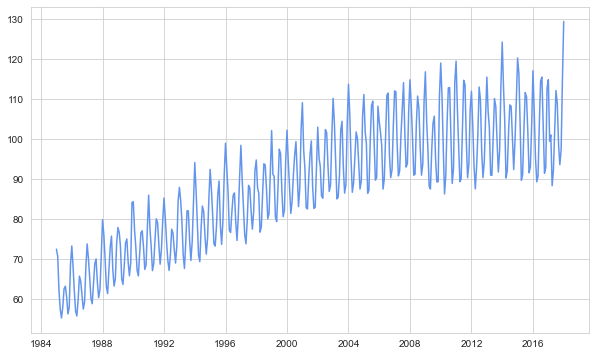

In [6]:
plt.figure(figsize = (10,6))
plt.plot(df, color='cornflowerblue', label='Original')

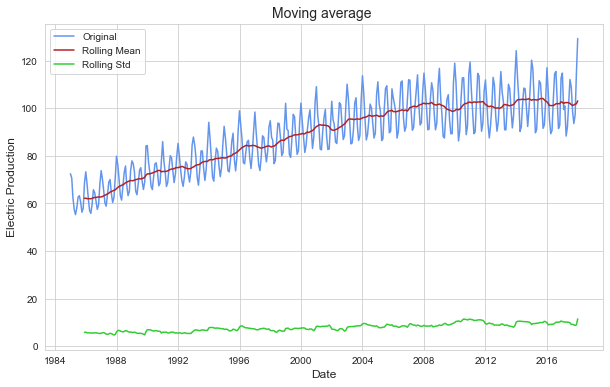

In [7]:
rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()
plt.figure(figsize = (10,6))
plt.plot(df, color='cornflowerblue', label='Original')
plt.plot(rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(rolling_std, color='limegreen', label='Rolling Std')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size  = 12)
plt.legend(loc = 'upper left')
plt.title('Moving average ', size = 14)
plt.show()

<a id = "4"></a><h1 id="Checking Stationarity"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Checking Stationarity</span></h1>

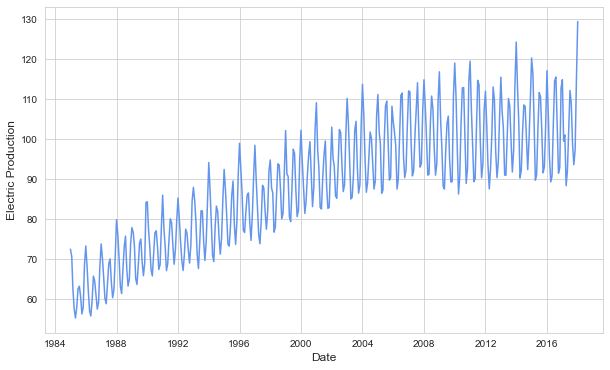

In [8]:
plt.figure(figsize = (10,6))
plt.plot(df['value'], color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.show()

Looking at the plot we can observe there is an **upward trend** over the period of time.

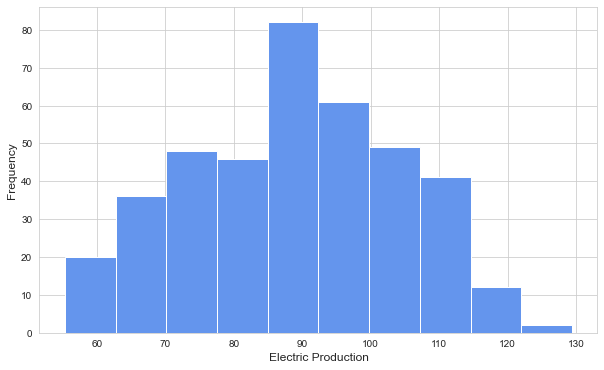

In [9]:
plt.figure(figsize = (10,6))
plt.hist(df['value'], color = 'cornflowerblue')
plt.xlabel('Electric Production', size = 12)
plt.ylabel('Frequency', size = 12)
plt.show()

In [10]:
print("Data Shape: {}".format(df.shape))
value_1 = df[0:199]
value_2 = df[200:397]

Data Shape: (397, 1)


We will proceed by splitting the data into two parts so that we can then check the **mean** and **variance** of the data.

<a id = "5"></a><h1 id="Mean of Data"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Mean of Data</p></h1>

In [11]:
print("Mean of value_1: {}".format(round(value_1.mean()[0],3)))
print("Mean of value_2: {}".format(round(value_2.mean()[0],3)))

Mean of value_1: 77.497
Mean of value_2: 100.258


<a id = "6"></a><h1 id="Variance"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Variance of Data</p></h1>

In [12]:
print("Variance of value_1: {}".format(round(value_1.var()[0],3)))
print("Variance of value_2: {}".format(round(value_2.var()[0],3)))

Variance of value_1: 123.226
Variance of value_2: 91.677


Augmented Dickey-Fuller Test is a common statistical test used to test whether a given time series is stationary or not. We can achieve this by defining the null and alternate hypothesis.

**Null Hypothesis:** Time Series is non-stationary. In another term, the series doesn’t depend on time.   
**Alternate Hypothesis:** Time Series is stationary. It gives a time-dependent trend.

**ADF or t Statistic < critical values:** Reject the null hypothesis, time series is stationary.   
**ADF or t Statistic > critical values:** Failed to reject the null hypothesis, time series is non-stationary.

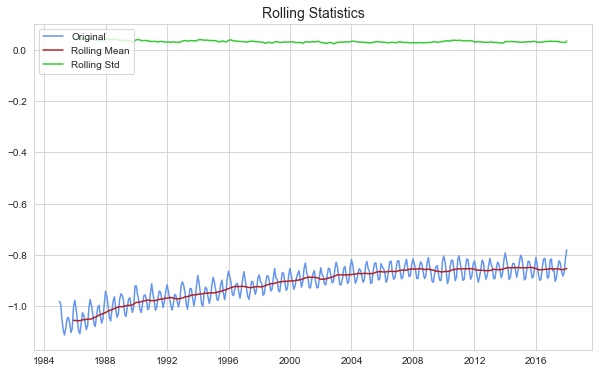

ADF Statistic: -3.879
p-value: 0.002
##################################
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
##################################
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [28]:
def adfuller_test(ts, window = 12):
    
    movingAverage = ts.rolling(window).mean()
    movingSTD = ts.rolling(window).std()
    
    plt.figure(figsize = (10,6))
    orig = plt.plot(ts, color='cornflowerblue',
                    label='Original')
    mean = plt.plot(movingAverage, color='firebrick',
                    label='Rolling Mean')
    std = plt.plot(movingSTD, color='limegreen',
                   label='Rolling Std')
    plt.legend(loc = 'upper left')
    plt.title('Rolling Statistics', size = 14)
    plt.show(block=False)
    
    adf = adfuller(ts, autolag='AIC')
    
    print('ADF Statistic: {}'.format(round(adf[0],3)))
    print('p-value: {}'.format(round(adf[1],3)))
    print("##################################")  
    print('Critical Values:')
    
    for key, ts in adf[4].items():
         print('{}: {}'.format(key, round(ts,3)))
    print("##################################")
    
    if adf[0] > adf[4]["5%"]:
        print("ADF > Critical Values")
        print ("Failed to reject null hypothesis, time series is non-stationary.")
    else:
        print("ADF < Critical Values")
        print ("Reject null hypothesis, time series is stationary.")
        
adfuller_test(df, window = 12)

The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact **non-stationary**.

<a id = "8"></a><h1 id="Converting Data to Stationary"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Converting Data to Stationary</span></h1>
<a id = "9"></a><h1 id="Logarithmic Transformation with Box-Cox"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Logarithmic Transformation with Box-Cox</p></h1>
The Box-Cox transform is a configurable data transform method that supports both square root and log transform, as well as a suite of related transforms.

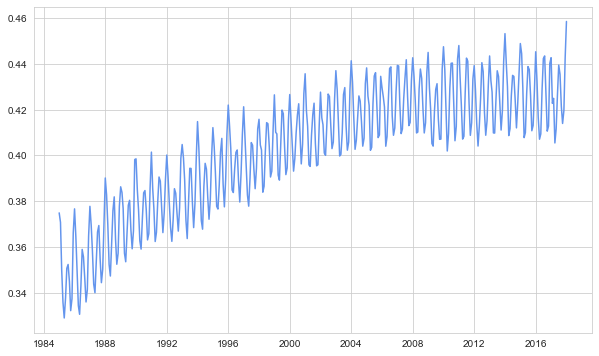

In [36]:
df_log_scaled = df
df_log_scaled['value'] =boxcox(df_log_scaled['value'],lmbda=0.0)
plt.figure(figsize=(10,6))
# after the trasorfmation
plt.plot(df_log_scaled, color = 'cornflowerblue')

<a id = "10"></a><h1 id="Removing Trend with Moving Average"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Removing Trend with Moving Average</p></h1>

A time series with a trend is called **non-stationary**.

An identified trend can be modeled. Once modeled, it can be removed from the time series dataset. This is called detrending the time series.

If a dataset does not have a trend or we successfully remove the trend, the dataset is said to be trend stationary.

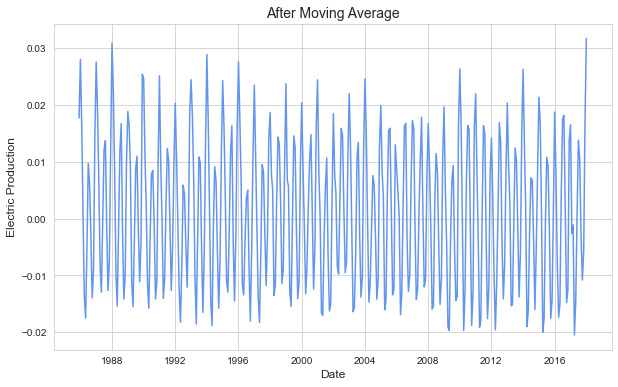

In [37]:
moving_avg = df_log_scaled.rolling(window=12).mean()
df_log_scaled_ma = df_log_scaled - moving_avg
df_log_scaled_ma.dropna(inplace=True)
plt.figure(figsize = (10,6))
plt.plot(df_log_scaled_ma, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Moving Average", size = 14)
plt.show()

<a id = "11"></a><h1 id="Exponential Decay Transformation"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Exponential Decay Transformation</p></h1>

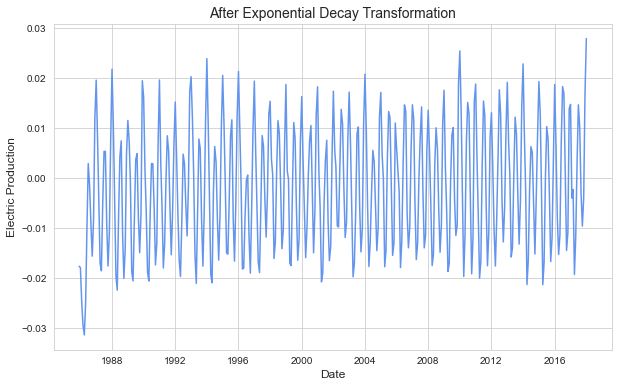

In [38]:
df_log_scaled_ma_ed = df_log_scaled_ma.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_lsma_sub_df_lsma_ed = df_log_scaled_ma - df_log_scaled_ma_ed
plt.figure(figsize = (10,6))
plt.plot(df_lsma_sub_df_lsma_ed - df_log_scaled_ma_ed, color='cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Electric Production', size = 12)
plt.title("After Exponential Decay Transformation", size = 14)
plt.show()

Let's test stationarity again.

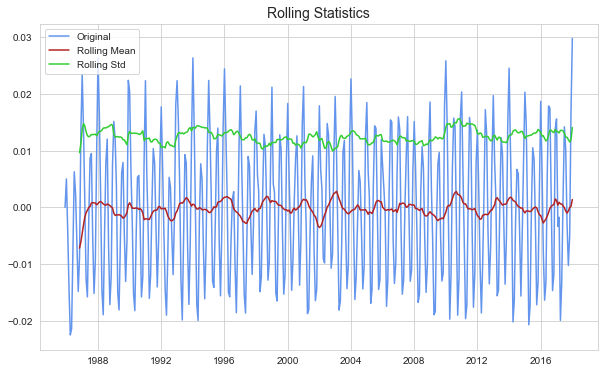

ADF Statistic: -7.16
p-value: 0.0
##################################
Critical Values:
1%: -3.448
5%: -2.869
10%: -2.571
##################################
ADF < Critical Values
Reject null hypothesis, time series is stationary.


In [39]:
adfuller_test(df_lsma_sub_df_lsma_ed, window = 12)

The p-value is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the series is stationary.

<a id = "12"></a><h1 id="Decomposition"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Decomposition</span></h1>

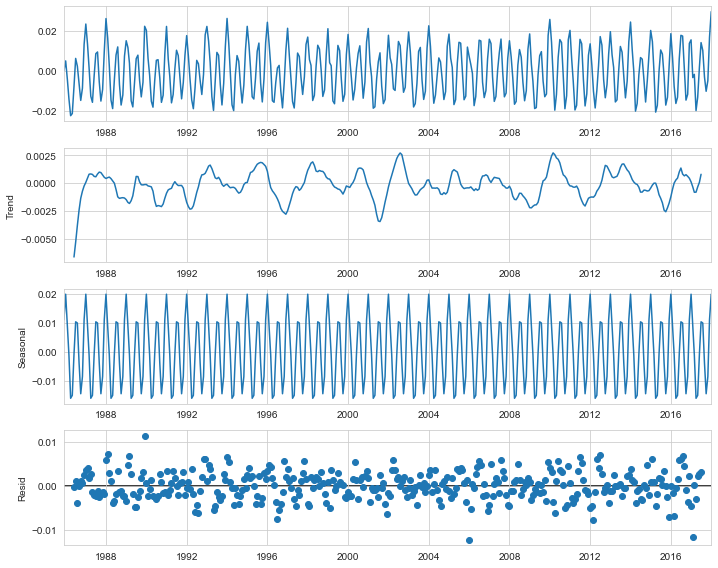

In [40]:
rcParams['figure.figsize']=10,8
df_seasonal_decompose = seasonal_decompose(df_lsma_sub_df_lsma_ed, 
                                           model='duplicative')
df_seasonal_decompose.plot()
plt.show()

<a id = "13"></a><h1 id="ACF & PACF"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">ACF & PACF</span></h1>

Autocorrelation and partial autocorrelation plots are heavily used in time series analysis and forecasting.

These are plots that graphically summarize the strength of a relationship with an observation in a time series with observations at prior time steps.

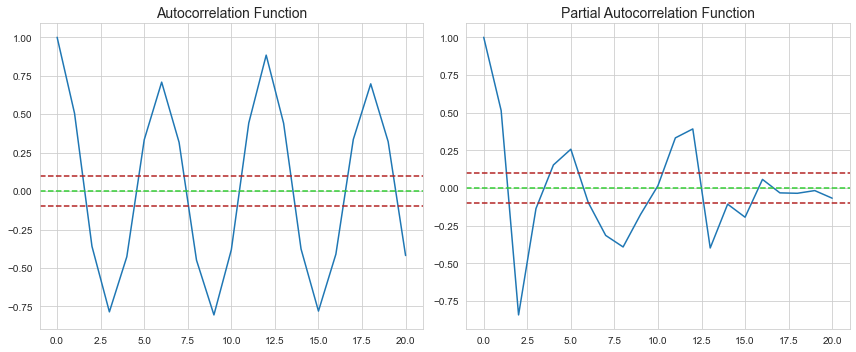

In [41]:
auto_c_f = acf(df_lsma_sub_df_lsma_ed, nlags=20)
partial_auto_c_f = pacf(df_lsma_sub_df_lsma_ed, nlags=20, method='ols')

fig, axs = plt.subplots(1, 2, figsize =(12,5))

plt.subplot(121)
plt.plot(auto_c_f)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.title('Autocorrelation Function', size = 14)            

plt.subplot(122)
plt.plot(partial_auto_c_f)
plt.axhline(y=0, linestyle='--', color='limegreen')
plt.axhline(y=-1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.axhline(y=1.96/np.sqrt(len(df_lsma_sub_df_lsma_ed)),
            linestyle='--', color='firebrick')
plt.title('Partial Autocorrelation Function', size = 14)
            
plt.tight_layout() 

<a id = "14"></a><h1 id="Forecasting Models"><span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:22px; color:#FBFAFC; ">Forecasting Models</span></h1>

<a id = "15"></a><h1 id="Persistence Model"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Persistence Model</p></h1>
Let’s say that we want to develop a model to predict the last 10 days of electric production in the dataset given all prior observations. The simplest model that we could use to make predictions would be to persist the last observation. We can call this a persistence model and it provides a baseline of performance for the problem that we can use for comparison with an autoregression model.

In [42]:
values = DataFrame(df_lsma_sub_df_lsma_ed.values)
persistence_df = concat([values.shift(1), values], axis=1)
persistence_df.columns = ['t-1', 't+1']
per_values = persistence_df.values

train = per_values[1:len(per_values)-10] 
test = per_values[len(per_values)-10:]

X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

def persistence(x):
    return x

predictions = []
for i in X_test:
    y_pred = persistence(i)
    predictions.append(y_pred)

persistence_score = mean_squared_error(y_test, predictions)
print('Persistence MSE: {}'.format(round(persistence_score,4)))

Persistence MSE: 0.0002


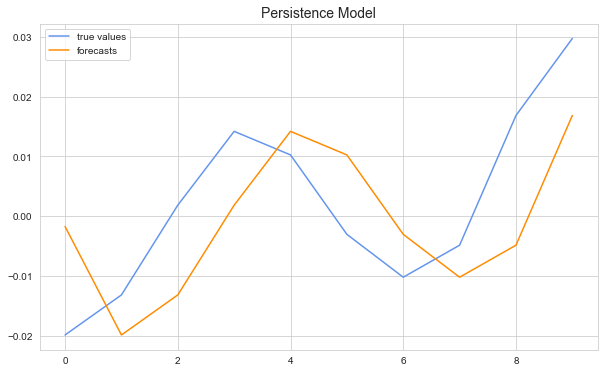

In [43]:
plt.figure(figsize = (10,6))
plt.plot(y_test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("Persistence Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

<a id = "16"></a><h1 id="Autoregression Model"><p  style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Autoregression Model</p></h1>
An autoregression model is a linear regression model that uses lagged variables as input variables.

We could calculate the linear regression model manually using the LinearRegession class in scikit-learn and manually specify the lag input variables to use.

Alternately, the statsmodels library provides an autoregression model where you must specify an appropriate lag value and trains a linear regression model. It is provided in the AutoReg class.

In [44]:
ar_values = df_lsma_sub_df_lsma_ed.values
train = ar_values[1:len(ar_values)-10] 
test = ar_values[len(ar_values)-10:]
model = ARIMA(train, order=(2,1,0))
AR_model = model.fit()

predictions = AR_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ar_score = mean_squared_error(test, predictions)
print('AR MSE: {}'.format(round(ar_score,4)))

AR MSE: 0.0004


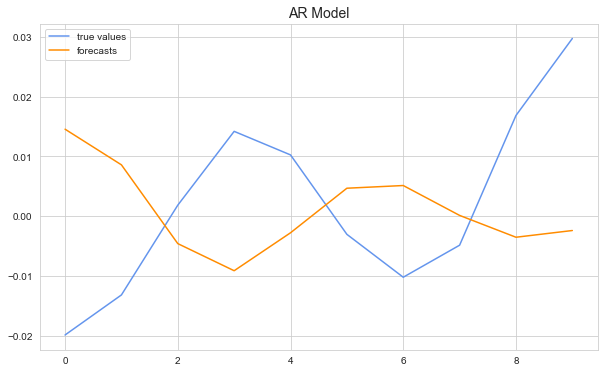

In [45]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("AR Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

<a id = "17"></a><h1 id="Moving Average Model"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Moving Average Model</p></h1>

In [46]:
model = ARIMA(train, order=(0,1,2))
MA_model = model.fit()

predictions = MA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
ma_score = mean_squared_error(test, predictions)
print('MA MSE: {}'.format(round(ma_score,4)))

MA MSE: 0.0003


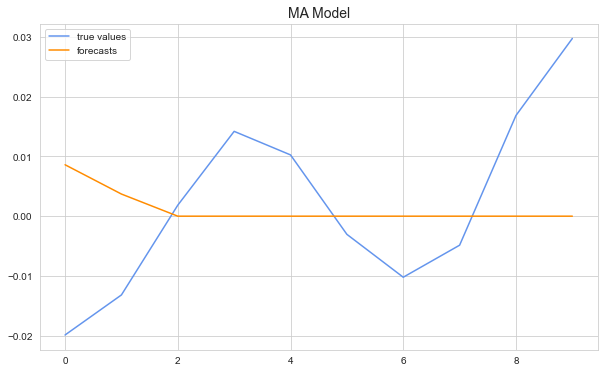

In [47]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("MA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

<a id = "18"></a><h1 id="ARIMA Model"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">ARIMA Model</p></h1>
The statsmodels library provides the capability to fit an ARIMA model.

An ARIMA model can be created using the statsmodels library as follows:

**1.** Define the model by calling ARIMA() and passing in the **p**, **d**, and **q** parameters.   
**2.** The model is prepared on the training data by calling the fit() function.   
**3.** Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

Let’s start off with something simple. We will fit an ARIMA model to the entire Electric Production dataset.

In [48]:
model = ARIMA(train, order=(2,1,2))
ARIMA_model = model.fit()

predictions = ARIMA_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
arima_score = mean_squared_error(test, predictions)
print('ARIMA MSE: {}'.format(round(arima_score,4)))

ARIMA MSE: 0.0002


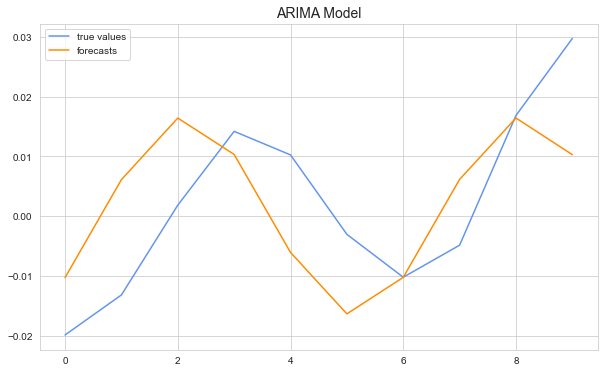

In [49]:
plt.figure(figsize = (10,6))
plt.plot(test, label = "true values", color = "cornflowerblue")
plt.plot(predictions,label = "forecasts", color='darkorange')
plt.title("ARIMA Model", size = 14)
plt.legend(loc = 'upper left')
plt.show()

<a id = "19"></a><h1 id="Mean Squared Errors"><p style="font-weight: bold; font-family:Verdana; font-size:18px; color:#47A8EC; ">Mean Squared Errors</p></h1>

In [50]:
errors = pd.DataFrame()
errors["Model"] = ["Persistence", "Autoregression", "Moving Average", "ARIMA"]
errors["MSE"] = [persistence_score, ar_score, ma_score, arima_score]
errors = errors.sort_values("MSE", ascending = True, ignore_index = True)
errors.index = errors.Model
del errors["Model"]

def coloring_bg(s, min_, max_, cmap='Reds', low=0, high=0):
    color_range = max_ - min_
    norm = colors.Normalize(min_ - (color_range * low), max_ + (color_range * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

errors.style.apply(coloring_bg,min_ =errors.min().min(),
               max_ = errors.max().max(), low = 0.1, high = 0.85)

,MSE
Model,
ARIMA,0.000164
Persistence,0.000166
Moving Average,0.000272
Autoregression,0.000419


**Reference:**   
https://machinelearningmastery.com/    
https://otexts.com/fpp2/index.html